## Libs and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
import os
import seaborn as sn
from torchsummary import summary

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.data import random_split

from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from typing import Type

In [2]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Read Data and create Train, test and validation sets

In [3]:
# Define transformations for normalization only (for validation and test)
transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
# Download CIFAR-10 dataset and apply transformations
train_SVHN = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_SVHN = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)
test_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
# Print the number of samples in the train and test sets
print(f"Number of SVHN training samples: {len(train_SVHN)}")
print(f"Number of SVHN testing samples: {len(test_SVHN)}")
print(f"Number of MNIST testing samples: {len(test_mnist)}")

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
Number of SVHN training samples: 73257
Number of SVHN testing samples: 26032
Number of MNIST testing samples: 10000


In [5]:
# Create data loaders for train and test sets
train_dataloader = torch.utils.data.DataLoader(dataset=train_SVHN, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_SVHN, batch_size=16, shuffle=False)
mnist_dataloader = torch.utils.data.DataLoader(dataset=test_mnist, batch_size=16, shuffle=True)

In [6]:
def convert_to_3ch(images):
    # images shape: (batch_size, 1, 28, 28)
    # Convert to (batch_size, 3, 28, 28)
    return torch.cat([images, images, images], dim=1)

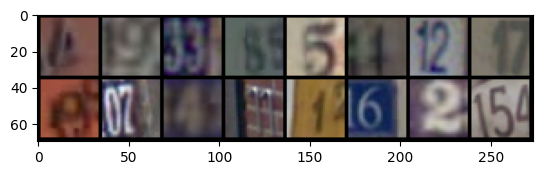

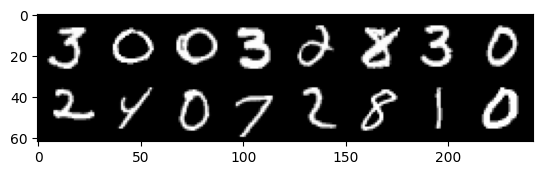

In [7]:
# Checking a sample batch and dataloader
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)
imshow(out)
inputs, classes = next(iter(mnist_dataloader))
inputs = convert_to_3ch(inputs)
out = torchvision.utils.make_grid(inputs)
imshow(out)

## Train

### Train function which include training the model and calculation of acc and loss in each epoch

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, train_dataloader, test_dataloader, mnist_dataloader):
    since = time.time()
    # model.load_state_dict(torch.load('model_weights.pth'))
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    test_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    test_acc = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 15)
        tic = time.time()
        # Each epoch has a training and validation phase
        ### Training
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        trainset_size = 0
        for batch_idx, data in enumerate(train_dataloader):
            inputs = data[0].to(device)
            labels = data[1].to(device)
            trainset_size += len(labels)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        scheduler.step()
        epoch_loss = running_loss / len(train_SVHN)
        epoch_acc = running_corrects.double() / len(train_SVHN)
        train_loss[epoch] = epoch_loss
        train_acc[epoch] = epoch_acc
        print(f'Training: Loss = {epoch_loss:.4f} Acc =  {epoch_acc:.4f}')
        ### Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        for batch_idx, data in enumerate(test_dataloader):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(test_SVHN)
            epoch_acc = running_corrects.double() / len(test_SVHN)

            val_loss[epoch] = epoch_loss
            val_acc[epoch] = epoch_acc
        print(f'SVHN Test: Loss = {epoch_loss:.4f} Acc =  {epoch_acc:.4f}')

        ## MNIST
        running_loss = 0.0
        running_corrects = 0
        for batch_idx, data in enumerate(mnist_dataloader):
            inputs = data[0].to(device)
            inputs = convert_to_3ch(inputs)
            labels = data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(test_mnist)
            epoch_acc = running_corrects.double() / len(test_mnist)

            test_loss[epoch] = epoch_loss
            test_acc[epoch] = epoch_acc
            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = copy.deepcopy(epoch_acc)
                best_model_wts = copy.deepcopy(model.state_dict())
        print(f'MNIST: Loss = {epoch_loss:.4f} Acc =  {epoch_acc:.4f}')
        toc = time.time()
        print(f'Time: {(toc-tic) // 60:.0f}m {(toc-tic) % 60:.0f}s')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss,train_acc,val_loss,val_acc, test_loss, test_acc

## Resnet18

### Basic Blocks

In [9]:
class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        # Multiplicative factor for the subsequent conv2d layer's output channels.
        # It is 1 for ResNet18 and ResNet34.
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels*self.expansion, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out

### ResNet Model

In [10]:
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        num_classes: int  = 1000
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            self.expansion = 1
        
        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*self.expansion, num_classes)
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or 
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [11]:
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=10)
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,864
              ReLU-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,864
              ReLU-7           [-1, 64, 56, 56]               0
        BasicBlock-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
             ReLU-12           [-1, 64, 56, 56]               0
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

### Main

In [12]:
# Create an instance of the model
model_1 = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=10)
model_1 = model_1.to(device)
# Define learning parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

model_ft,train_loss,train_acc,val_loss,val_acc, test_loss, test_acc = train_model(model_1, criterion,
                                optimizer, exp_lr_scheduler, num_epochs=10, train_dataloader=train_dataloader, test_dataloader=test_dataloader, mnist_dataloader=mnist_dataloader)

Epoch 0/9
---------------
Training: Loss = 2.2417 Acc =  0.1882
SVHN Test: Loss = 2.2249 Acc =  0.1959
MNIST: Loss = 2.3366 Acc =  0.1135
Time: 1m 3s

Epoch 1/9
---------------
Training: Loss = 2.2320 Acc =  0.1895
SVHN Test: Loss = 2.1981 Acc =  0.1969
MNIST: Loss = 2.3757 Acc =  0.1135
Time: 1m 1s

Epoch 2/9
---------------
Training: Loss = 1.6940 Acc =  0.4048
SVHN Test: Loss = 1.0181 Acc =  0.6773
MNIST: Loss = 2.3026 Acc =  0.4646
Time: 0m 59s

Epoch 3/9
---------------
Training: Loss = 0.8139 Acc =  0.7490
SVHN Test: Loss = 0.6982 Acc =  0.7952
MNIST: Loss = 3.6518 Acc =  0.3290
Time: 0m 57s

Epoch 4/9
---------------
Training: Loss = 0.5593 Acc =  0.8325
SVHN Test: Loss = 0.5627 Acc =  0.8352
MNIST: Loss = 2.2361 Acc =  0.5443
Time: 0m 58s

Epoch 5/9
---------------
Training: Loss = 0.4557 Acc =  0.8646
SVHN Test: Loss = 0.4508 Acc =  0.8747
MNIST: Loss = 2.1752 Acc =  0.5718
Time: 0m 58s

Epoch 6/9
---------------
Training: Loss = 0.3971 Acc =  0.8838
SVHN Test: Loss = 0.4054 A

### Plot acc and loss for each epoch

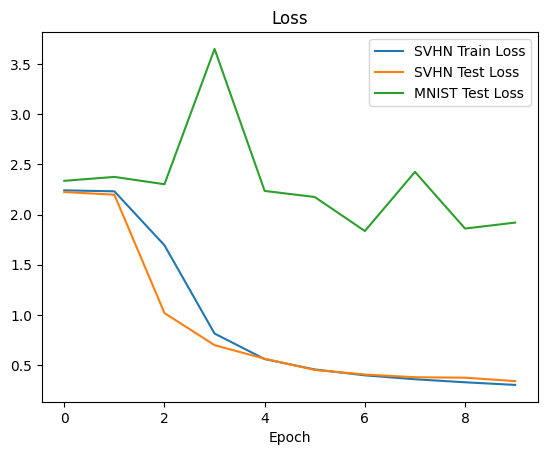

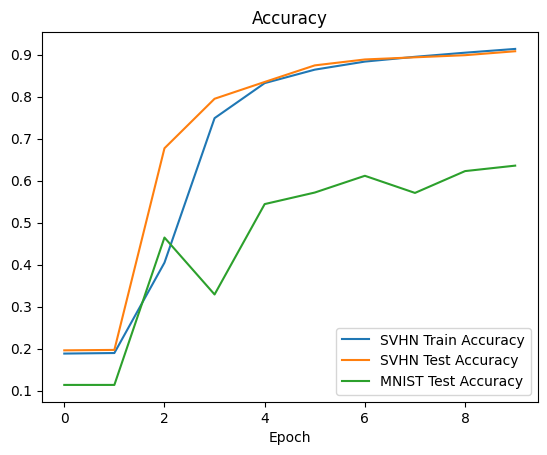

In [13]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(test_loss)
plt.legend(['SVHN Train Loss','SVHN Test Loss', 'MNIST Test Loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()
plt.plot(train_acc)
plt.plot(val_acc)
plt.plot(test_acc)
plt.legend(['SVHN Train Accuracy','SVHN Test Accuracy', 'MNIST Test Accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Test

### Load test data and give it to the trained model

In [14]:
labels = torch.tensor([])
preds = torch.tensor([])
model_ft.eval()
for batch_idx, data in enumerate(mnist_dataloader):
    # for inputs, labels in test_dataloader:
    inputs = data[0].to(device)
    inputs = convert_to_3ch(inputs)
    labels_temp = data[1].to(device)
    with torch.no_grad():
        outputs = model_ft(inputs)
        _, preds_temp = torch.max(outputs, 1)
    labels = torch.cat([labels, labels_temp.cpu()], dim=0)
    preds = torch.cat([preds, preds_temp.cpu()], dim=0)
    torch.cuda.empty_cache()

### Test accuracy and confusion matrix

Accuracy: 0.64
confusion matrix=
 [[566   0 134   1 205   0  16   2   1  55]
 [  3 539   1   0 492   0   4  92   3   1]
 [  4   0 824  51  21   1   0  91  22  18]
 [  4   3  30 575  51 111   9  34  52 141]
 [  0  65   1   0 829   2   5  13  10  57]
 [  0   7   3   2  46 786  20   5   4  19]
 [ 18   0   1   0 568  38 250   0   0  83]
 [  3  54  18   2   3   6   0 920   3  19]
 [  4   6  31  27  42  28 116  55 642  23]
 [  1  51  14   1  30   9   1 469   5 428]]


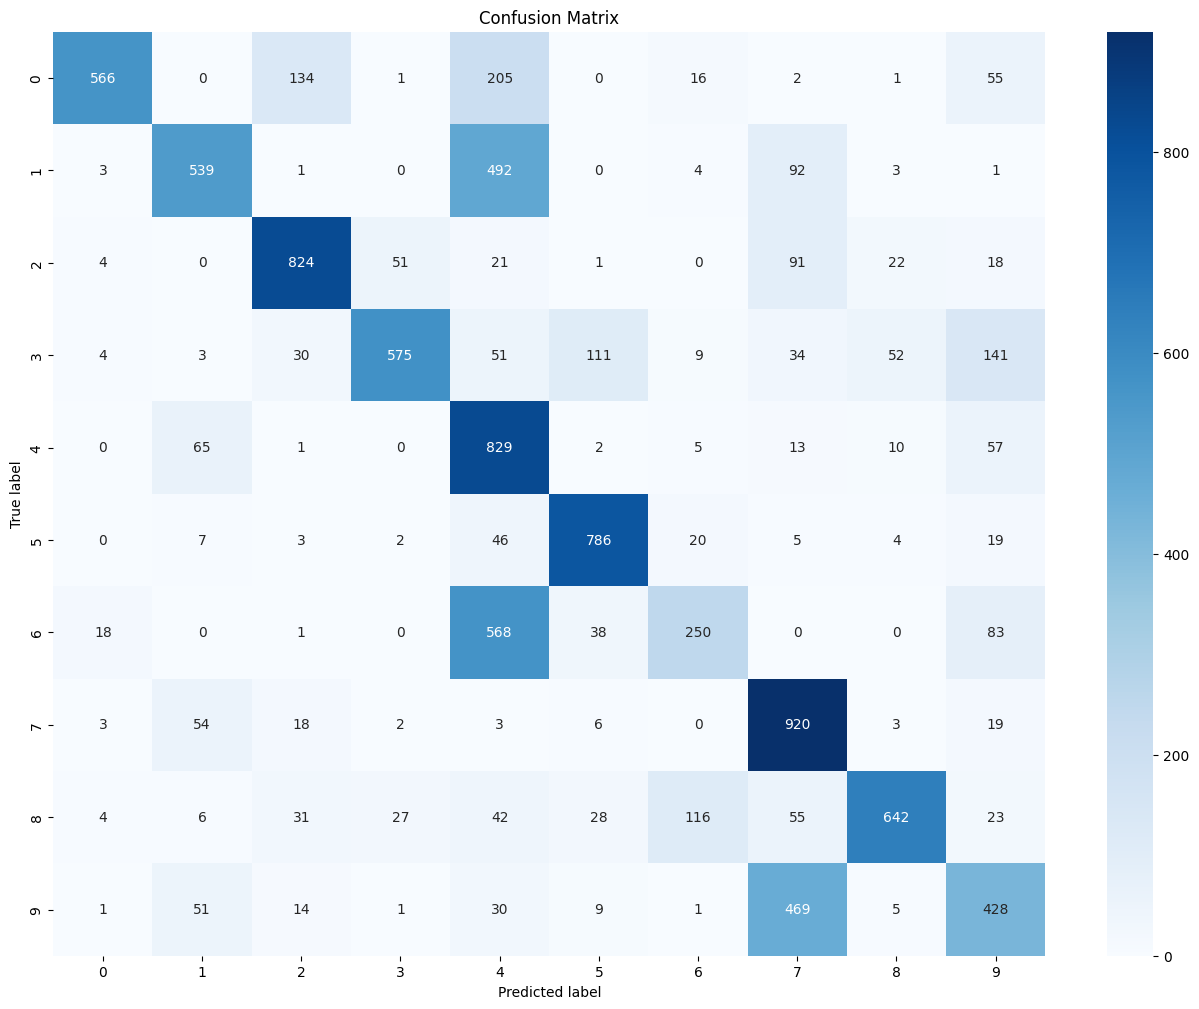

In [15]:
import sklearn
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

print(f"Accuracy: {accuracy:.2f}")
from sklearn.metrics import confusion_matrix , classification_report
class_names = ['0','1','2','3','4','5','6','7','8','9']
confusion_mtx = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
print("confusion matrix=\n",confusion_mtx)
plt.figure(figsize=(16,12))
sn.heatmap(confusion_mtx, annot=True,cmap="Blues", fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()